In [2]:
# Import packages
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
import math
import datetime
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
# Measure multicolinearity
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Set path to directory
sys.path.append('/Users/mikelgallo/repos/Barcelona-prices') # main path to repo

In [4]:
#Import own modules
import inferences as hh
from inferences import *

In [5]:
# Load dataset
df = pd.read_csv('./train.csv')
dt = pd.read_csv('./test.csv')

### Variable description

1) num_rooms: # bedrooms in an apartment. (numeric)

2) num_baths: # of bathrooms in an apartment.  (numeric)

3) square_meters: total area or size of the apartment, measured in square meters. (numeric)

4) orientation: specifies the compass direction it faces or the direction in which its windows are oriented. (categorical)

5) year_built: year in which the apartment was constructed or built.(numeric)(obtain age)

6) door: Specific door number or identifier associated with the apartment within a building or complex.(obtain floor)

7) is_furnished: This variable indicates whether the apartment is offered or equipped with furniture.(boolean)(categ)

8) has_pool: Apartment has a swimming pool as part of its amenities or shared facilities.(boolean)(categorical)

9) neighborhood: Specific neighborhood or locality in which the apartment is situated within Barcelona.(Categorical)

10) num_crimes: Count or frequency of reported crimes that have occurred in the vicinity of the apartment's location.

11) has_ac: Apartment is equipped with an air conditioning system.(boolean)(categ)

12) accepts_pets: It denotes whether the apartment allows or accepts pets as tenants or residents.

13) num_supermarkets: Count or availability of supermarkets in close proximity to the apartment.

#### price: It represents the price of the apartment, typically measured in a specific currency (e.g., Euros). It is the dependent variable in the prediction task and serves as the target value to be estimated or predicted using the other variables.

In [5]:
# Shape of our dataset
print(df.shape)
print(dt.shape)

(8000, 15)
(2000, 14)


#### Interesting Features -  before preprocessing and exploration
----------------Numerical
- abs(square_meters) (good)
- age
- rooms per squaremeter
- sqrmet per room
- baths per rooms
- rooms per bath
- num_crimes (good)

----------------Categorical
- neighborhood (good)
- is_furnished
- age range
- floor (good)
- orientation

----------------Other potential


### Variable modification

In [12]:
#transform negative square-meters to absolute values
df['square_meters'] = df['square_meters'].abs()
dt['square_meters'] = dt['square_meters'].abs()

In [13]:
#Floor of the apartment
df['floor'] = df['door'].str[:1]
dt['floor'] = dt['door'].str[:1]

In [14]:
# Change floor data type to numeric
df['floor'] = pd.to_numeric(df['floor'])
dt['floor'] = pd.to_numeric(dt['floor'])

In [15]:
# Calculate age of apartment
df['today'] = 2023
df['age'] = df['today'] - df['year_built']
dt['today'] = 2023
dt['age'] = dt['today'] - dt['year_built']

In [16]:
# Replace  True and False for 1 and 0
# Replace 'soxth' for 'south'
for i in df.columns:
    df[i] = df[i].replace('soxth','south').replace(False,0).replace(True,1).replace('False',0).replace('True',1)

In [17]:
for i in dt.columns:
    dt[i] = dt[i].replace('soxth','south').replace(False,0).replace(True,1).replace('False',0).replace('True',1)

#### Summary Statistics

In [23]:
#Create dictionary for train set with summary statistics
df_diction = pop_parameters_dict(df[['num_rooms','num_baths','square_meters','age','num_crimes','price','floor']])

In [24]:
#Create dictionary for test set with summary statistics
dt_diction = pop_parameters_dict(dt[['num_rooms','num_baths','square_meters','age','num_crimes','floor']])

In [25]:
pop_parameters(df[['num_rooms','num_baths','square_meters','age','num_crimes','price','floor']])

,size,datatype,unique_values,mean,stdv,min,per25,median,per75,max,IQRs,lower_bound,upper_bound
num_rooms,8000,float64,39,2.87,5.30,1.0,1.00,2.0,4.0,97.0,3.00,0.00,8.50
num_baths,8000,float64,4,1.99,0.82,1.0,1.00,2.0,3.0,3.0,2.00,0.00,6.00
square_meters,8000,float64,145,109.16,35.37,2.0,79.00,110.0,140.0,170.0,61.00,0.00,231.50
age,8000,float64,73,37.68,20.59,2.0,20.00,38.0,55.0,73.0,35.00,0.00,107.50
num_crimes,8000,float64,12,2.80,3.45,0.0,0.00,1.0,6.0,10.0,6.00,0.00,15.00
price,8000,int64,1279,1099.62,271.67,195.0,905.75,1104.0,1295.0,2095.0,389.25,321.88,1878.88
floor,8000,float64,10,4.67,2.72,1.0,2.00,5.0,7.0,9.0,5.00,0.00,14.50


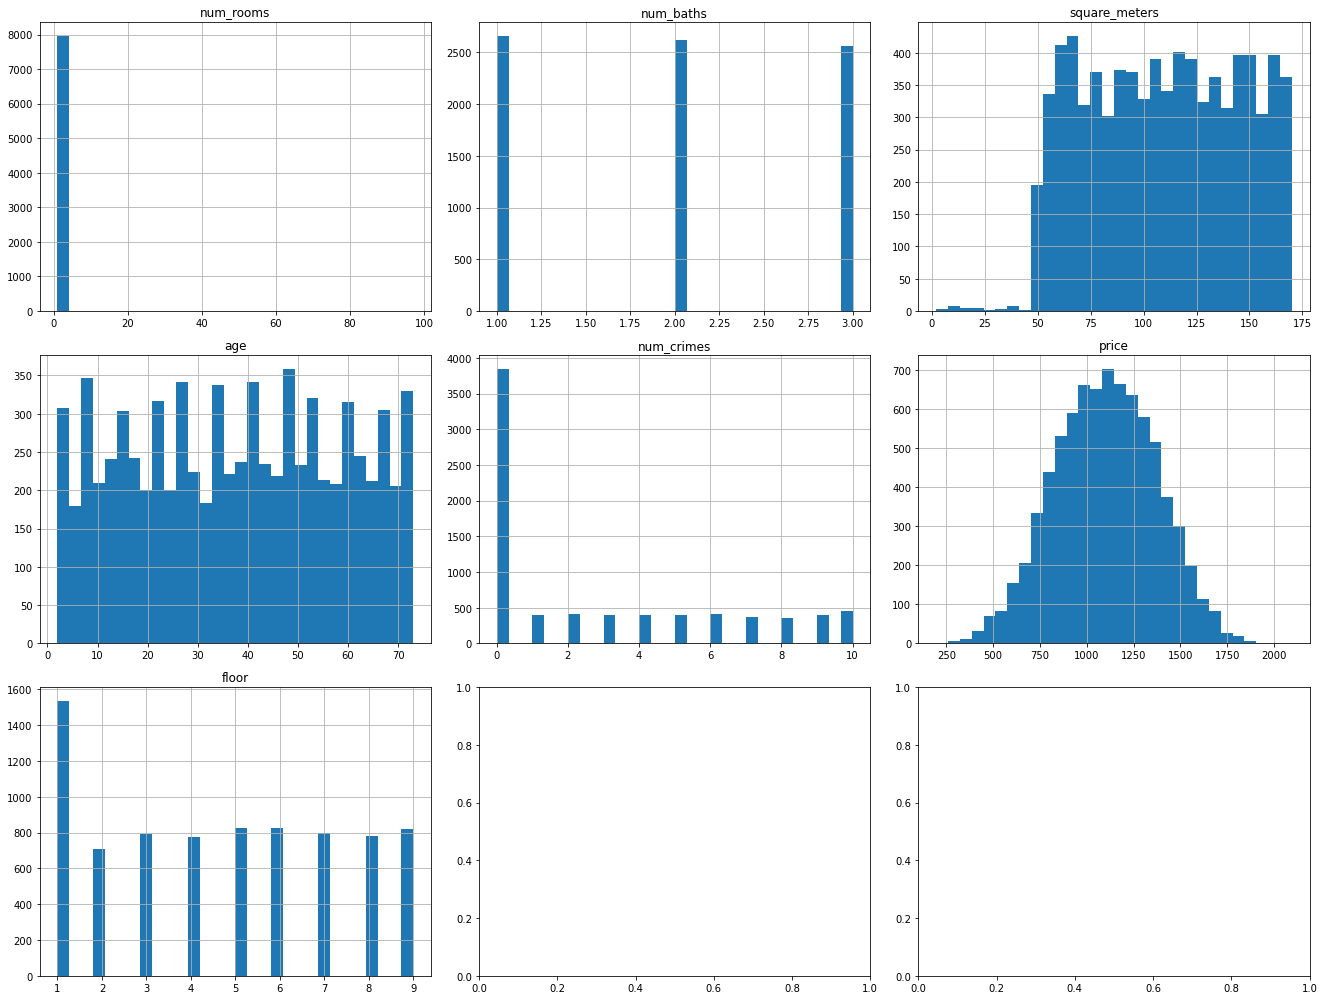

In [26]:
plot_hist_mult(df[['num_rooms','num_baths','square_meters','age','num_crimes','price','floor']],3,3,30)

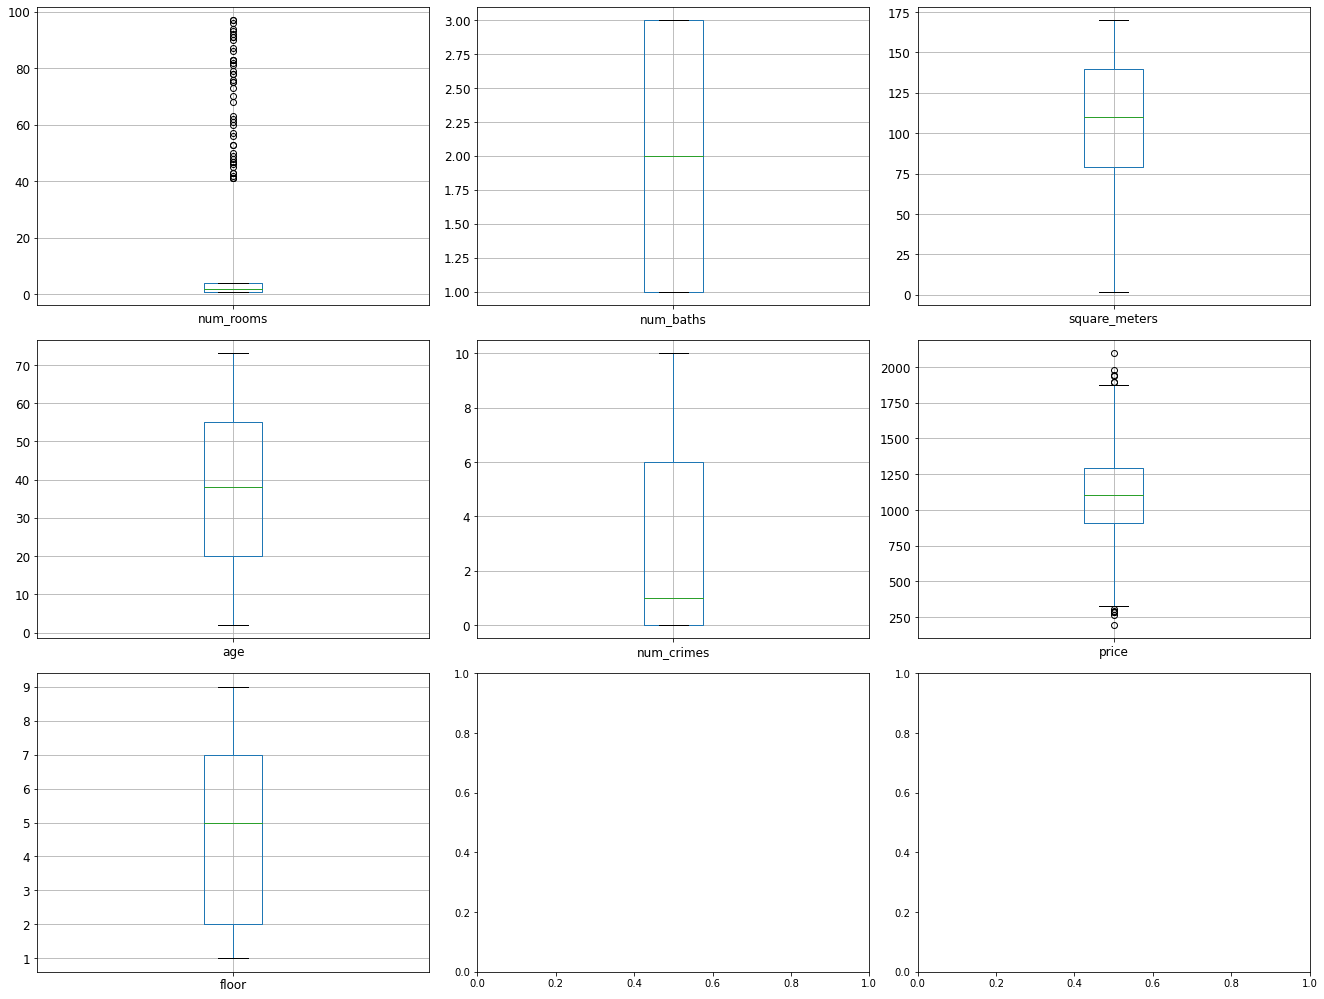

In [27]:
plot_box_mult(df[['num_rooms','num_baths','square_meters','age','num_crimes','price','floor']],3,3)

### Outlier Treatment

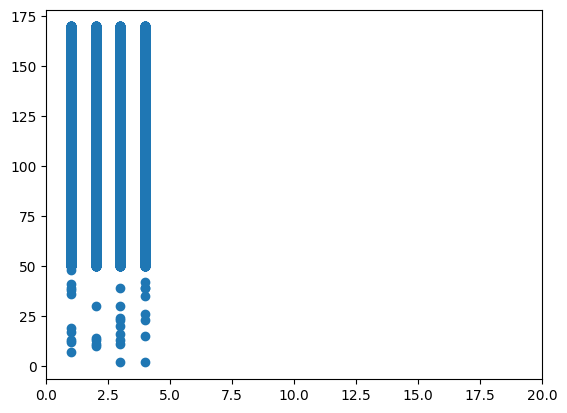

In [17]:
plt.scatter(df['num_rooms'],df['square_meters'])
plt.xlim(0,20)
plt.show()

##### Dealing with Number of Rooms

In [28]:
#Train
df.loc[df["num_rooms"] > df_diction['num_rooms']['upper_bound'], "num_rooms"] = df_diction['num_rooms']['median']

In [29]:
#Test
dt.loc[dt["num_rooms"] > dt_diction['num_rooms']['upper_bound'], "num_rooms"] = dt_diction['num_rooms']['median']

### Exploring Square-meters

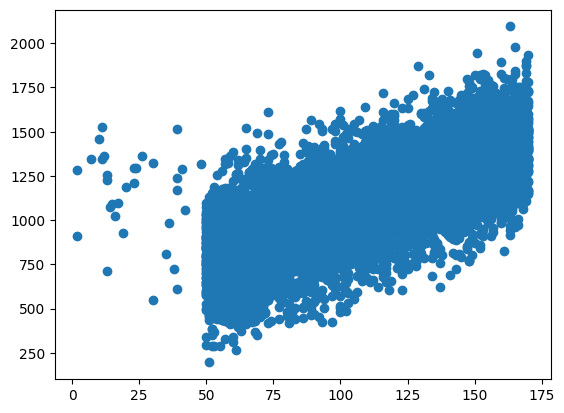

In [20]:
plt.scatter(df['square_meters'],df['price'])
plt.show()

##### Replacing outlier sqr meters with nans

In [30]:
#Train
df.loc[df["square_meters"] < 50, "square_meters"] = np.nan

In [31]:
#Test
dt.loc[df["square_meters"] < 50, "square_meters"] = np.nan

## Managing Missing Values

In [32]:
# Check for % missing values
df.isna().mean().round(2)

id                  0.00
num_rooms           0.00
num_baths           0.02
square_meters       0.02
orientation         0.29
year_built          0.02
door                0.02
is_furnished        0.02
has_pool            0.02
neighborhood        0.02
num_crimes          0.02
has_ac              0.02
accepts_pets        0.02
num_supermarkets    0.82
price               0.00
floor               0.02
today               0.00
age                 0.02
dtype: float64

<AxesSubplot:>

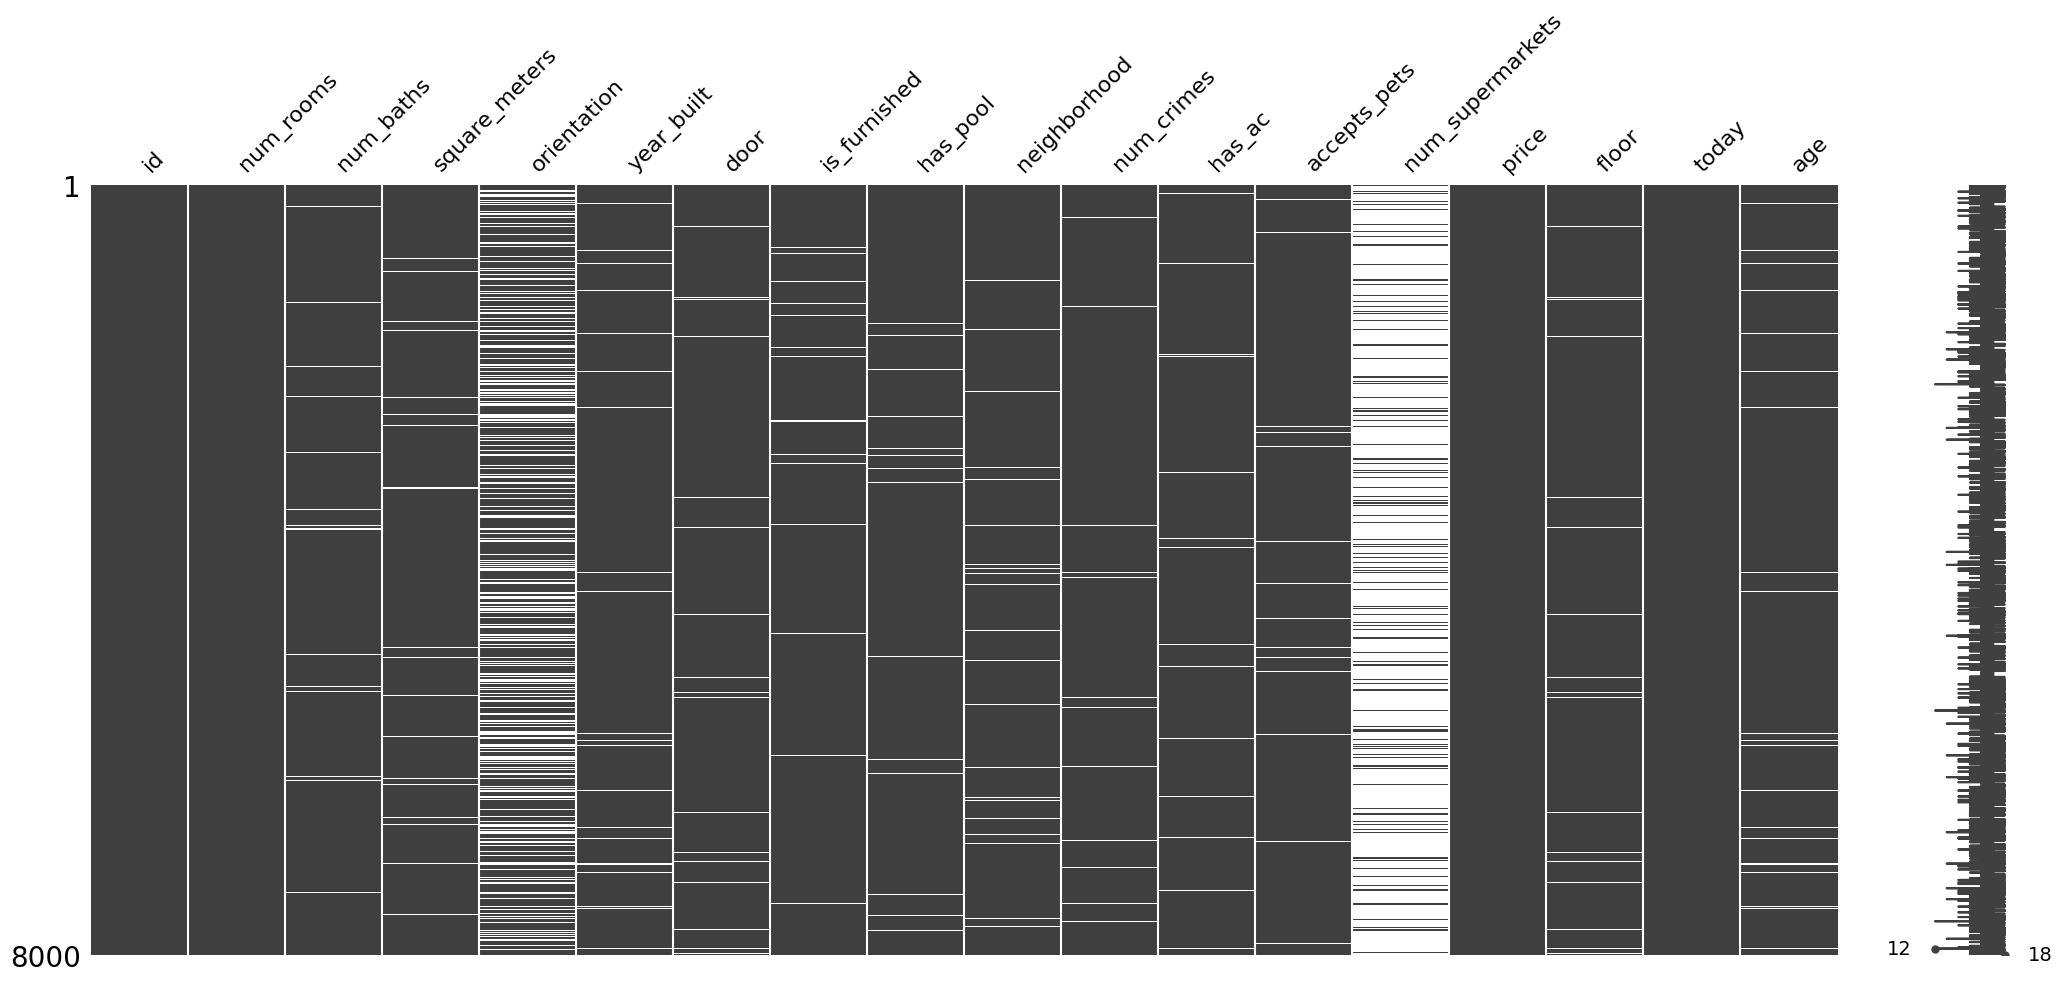

In [24]:
#  Take a look at the location of the missing values
msno.matrix(df)

### Correlation of missing values between columns

In [25]:
#msno.heatmap(df)

In [26]:
#msno.dendrogram(df)

In [33]:
df.columns

Index(['id', 'num_rooms', 'num_baths', 'square_meters', 'orientation',
       'year_built', 'door', 'is_furnished', 'has_pool', 'neighborhood',
       'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'price',
       'floor', 'today', 'age'],
      dtype='object')

In [34]:
df2 = df.copy()

### Missing Value Imputations

In [35]:
#train, variables of interest
variables = ['square_meters','age','orientation','floor','num_rooms','num_baths','accepts_pets','has_pool','num_crimes','has_ac','is_furnished','price']

In [36]:
#test, variables of interest (No Price)
variables_t = ['square_meters','age','orientation','floor','num_rooms','num_baths','accepts_pets','has_pool','num_crimes','has_ac','is_furnished']

In [37]:
#Create impt code for orientation
df['orientation'] = df['orientation'].replace('south',1).replace('west',2).replace('north',3).replace('east',4)
dt['orientation'] = dt['orientation'].replace('south',1).replace('west',2).replace('north',3).replace('east',4)

In [38]:
#KNN imputation in Train data

# Create KNNImputer object with k=3
imputer = KNNImputer(n_neighbors=3)
# Perform KNN imputation
imputed_data = imputer.fit_transform(df[variables])
# Update the original DataFrame with imputed values
df[variables] = imputed_data

In [39]:
df.head()

,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,price,floor,today,age
0,9255,1.0,1.0,88.000000,3.666667,1956.0,3º - 1a,0.0,0.0,Sant Martí,2.0,1.0,1.0,NaN,1096.0,3.0,2023,67.0
1,1562,4.0,1.0,133.000000,2.000000,1960.0,7º - 2a,0.0,0.0,Sants,4.0,0.0,0.0,2.0,1396.0,7.0,2023,63.0
2,1671,2.0,3.0,137.000000,2.000000,2000.0,1º - 1a,0.0,1.0,Eixample,0.0,0.0,0.0,NaN,1263.0,1.0,2023,23.0
3,6088,1.0,2.0,136.333333,2.333333,2002.0,6º - 1a,0.0,1.0,Sants,5.0,0.0,0.0,NaN,1290.0,6.0,2023,21.0
4,6670,2.0,1.0,70.000000,3.333333,1979.0,5º - 1a,1.0,0.0,Gràcia,0.0,0.0,1.0,3.0,962.0,5.0,2023,44.0


In [42]:
#KNN imputation in Train data

# Create KNNImputer object with k=3
imputer1 = KNNImputer(n_neighbors=3)
# Perform KNN imputation
imputed_datas = imputer1.fit_transform(dt[variables_t])
# Update the original DataFrame with imputed values
dt[variables_t] = imputed_datas

In [43]:
dt.head()

,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,floor,today,age
0,6253,2.000000,1.0,152.0,2.000000,2012.0,5º - 4a,1.0,1.0,Les Cors,0.0,0.0,0.0,NaN,5.0,2023,11.0
1,4685,3.000000,2.0,90.0,4.000000,1957.0,10º - 1a,1.0,0.0,Ciutat Vella,2.0,0.0,1.0,3.0,1.0,2023,66.0
2,1732,3.333333,2.0,86.0,3.333333,1991.0,5º - 2a,0.0,0.0,Eixample,0.0,0.0,1.0,NaN,5.0,2023,32.0
3,4743,3.333333,3.0,164.0,2.333333,2002.0,8º - 4a,0.0,1.0,Nou Barris,7.0,0.0,0.0,NaN,8.0,2023,21.0
4,4522,2.000000,1.0,99.0,3.000000,1984.0,8º - 4a,1.0,1.0,Sant Andreu,0.0,1.0,0.0,3.0,8.0,2023,39.0


In [44]:
# Check for % missing values
df.isna().mean().round(2)

id                  0.00
num_rooms           0.00
num_baths           0.00
square_meters       0.00
orientation         0.00
year_built          0.02
door                0.02
is_furnished        0.00
has_pool            0.00
neighborhood        0.02
num_crimes          0.00
has_ac              0.00
accepts_pets        0.00
num_supermarkets    0.82
price               0.00
floor               0.00
today               0.00
age                 0.00
dtype: float64

In [46]:
df33 = df.copy()

In [47]:
# Calculating the mean crime for each neighborhood
mean_crime = df.groupby('neighborhood')['num_crimes'].mean()

# Encoding the categorical variable 'Country' using target encoding
df['neighborhood_Encoded'] = df['neighborhood'].map(mean_crime)

In [48]:
# Calculating the mean crime for each neighborhood
mean_crime = dt.groupby('neighborhood')['num_crimes'].mean()

# Encoding the categorical variable 'Country' using target encoding
dt['neighborhood_Encoded'] = dt['neighborhood'].map(mean_crime)

In [49]:
# Calculating the mean mkt for each neighborhood
mean_m = df.groupby('neighborhood')['num_supermarkets'].mean()

# Encoding the categorical variable 'market' using target encoding
df['supermarkets_Encoded'] = df['neighborhood'].map(mean_m)

In [50]:
# Calculating the mean mkt for each neighborhood
mean_m = dt.groupby('neighborhood')['num_supermarkets'].mean()

# Encoding the categorical variable 'market' using target encoding
dt['supermarkets_Encoded'] = dt['neighborhood'].map(mean_m)

In [42]:
# Remove Columns
#df = df.drop(['today','num_supermarkets','neighborhood','door','year_built'], axis=1)

### Creating  dummies

In [43]:
#plt.scatter(df['age'],df['price'])
#plt.show()

In [52]:
#New Range
df['age_range'] = np.where(df['age']<25, '0-25 years',
                   np.where(df['age']<50, '25-50 years',
                   np.where(df['age']<75, '50-75 years', 
                   np.where(df['age']<100,'75-100 years','>100 years'))))

In [53]:
#New Range
dt['age_range'] = np.where(dt['age']<25, '0-25 years',
                   np.where(dt['age']<50, '25-50 years',
                   np.where(dt['age']<75, '50-75 years', 
                   np.where(dt['age']<100,'75-100 years','>100 years'))))

In [54]:
#Return Orientation to original values
df['orientation'] = df['orientation'].round(0)
dt['orientation'] = dt['orientation'].round(0)

In [55]:
#Create impt code for neighborhood
df['orientation'] = df['orientation'].replace(1,'south').replace(2,'west').replace(3,'north').replace(4,'east')
dt['orientation'] = dt['orientation'].replace(1,'south').replace(2,'west').replace(3,'north').replace(4,'east')

In [56]:
#Change variables again
variables = ['square_meters','age','floor','num_rooms','num_baths','accepts_pets','has_pool','num_crimes','has_ac','is_furnished','price','neighborhood_Encoded','supermarkets_Encoded']
variables_t = ['square_meters','age','floor','num_rooms','num_baths','accepts_pets','has_pool','num_crimes','has_ac','is_furnished','neighborhood_Encoded','supermarkets_Encoded']


In [57]:
# Perform KNN imputation to obtain missing encoded neighborhood
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(df[variables])

# Update the original DataFrame with imputed values
df[variables] = imputed_data

In [58]:
# Perform KNN imputation to obtain missing encoded neighborhood
imputer_t = KNNImputer(n_neighbors=3)
imputed_data_t = imputer_t.fit_transform(dt[variables_t])

# Update the original DataFrame with imputed values
dt[variables_t] = imputed_data_t

####  Create Dummy variables for age_range and orientation

In [59]:
# Apply one-hot encoding to orientation
dummies = pd.get_dummies(df['orientation'], prefix='o')
df= pd.concat([df, dummies], axis=1)

In [60]:
# Apply one-hot encoding to orientation
dummies = pd.get_dummies(dt['orientation'], prefix='o')
dt= pd.concat([dt, dummies], axis=1)

In [61]:
# Apply one-hot encoding to age range
dummies_2 = pd.get_dummies(df['age_range'], prefix='a')
df = pd.concat([df, dummies_2], axis=1)

In [62]:
# Apply one-hot encoding to age range
dummies_t = pd.get_dummies(dt['age_range'], prefix='a')
dt = pd.concat([dt, dummies_t], axis=1)

### Creation of new variables

In [63]:
df['baths_per_room'] = df['num_baths']/df['num_rooms']
df['sqrmt_per_room'] = df['square_meters']/df['num_rooms']
df['rooms_per_sqrmt'] = df['num_rooms']/df['square_meters']

In [64]:
dt['baths_per_room'] = dt['num_baths']/dt['num_rooms']
dt['sqrmt_per_room'] = dt['square_meters']/dt['num_rooms']
dt['rooms_per_sqrmt'] = dt['num_rooms']/dt['square_meters']

In [57]:
#df_age = df['age_range'].value_counts().reset_index()

In [58]:
#plt.bar(df_age['index'],df_age['age_range'])
#plt.show()
#df.columns.to_list()

### Correlation and Multicolinearity

In [65]:
#Change variables again
variables = ['id',
 'num_rooms',
 'num_baths',
 'square_meters',
 'is_furnished',
 'has_pool',
 'num_crimes',
 'has_ac',
 'accepts_pets',
 'price',
 'floor',
 'age',
 'neighborhood_Encoded',
 'o_east',
 'o_north',
 'o_south',
 'o_west',
 'a_0-25 years',
 'a_25-50 years',
 'a_50-75 years',
 'supermarkets_Encoded',
 'baths_per_room',
 'sqrmt_per_room',
 'rooms_per_sqrmt']

In [66]:
#Change variables again
variables_y = [
 'num_rooms',
 'num_baths',
 'square_meters',
 'num_crimes',
 'price',
 'floor',
 'age',
 'neighborhood_Encoded',
 'o_east',
 'o_north',
 'o_south',
 'o_west',
 'a_0-25 years',
 'a_25-50 years',
 'a_50-75 years',
 'supermarkets_Encoded',
]

In [67]:
df[variables].corr()

,id,num_rooms,num_baths,square_meters,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,price,...,o_north,o_south,o_west,a_0-25 years,a_25-50 years,a_50-75 years,supermarkets_Encoded,baths_per_room,sqrmt_per_room,rooms_per_sqrmt
id,1.000000,-0.000040,0.003542,0.014846,0.014386,-0.003598,0.010986,-0.006081,-0.000734,0.005516,...,0.006917,-0.023117,0.017139,0.006087,0.008916,-0.015138,0.007563,-0.007700,0.001565,-0.012709
num_rooms,-0.000040,1.000000,-0.000131,0.016432,0.008737,0.014312,-0.002701,-0.001932,0.004964,0.070241,...,-0.000964,-0.008080,0.020882,0.003815,0.003959,-0.007817,-0.003989,-0.711155,-0.775207,0.741250
num_baths,0.003542,-0.000131,1.000000,0.001597,0.010746,-0.012559,0.018416,0.009368,0.009728,0.027062,...,-0.008902,-0.002758,0.016980,0.006366,-0.004916,-0.001231,-0.007162,0.560950,-0.006813,-0.003039
square_meters,0.014846,0.016432,0.001597,1.000000,0.007056,-0.014618,-0.015497,-0.028208,0.003099,0.722423,...,-0.003793,0.007877,0.012723,-0.023362,0.007043,0.015793,-0.014379,-0.015089,0.468113,-0.570859
is_furnished,0.014386,0.008737,0.010746,0.007056,1.000000,0.002771,0.005764,-0.012631,-0.001226,0.007922,...,0.002406,0.008052,-0.013014,0.004202,0.006579,-0.010885,0.003282,-0.001916,-0.001451,0.004685
has_pool,-0.003598,0.014312,-0.012559,-0.014618,0.002771,1.000000,-0.005809,0.005700,0.001649,0.000406,...,0.001399,-0.003326,0.004888,-0.016349,-0.010533,0.026905,-0.005589,-0.022030,-0.019362,0.017670
num_crimes,0.010986,-0.002701,0.018416,-0.015497,0.005764,-0.005809,1.000000,0.003897,0.018394,-0.292802,...,-0.016291,0.003454,0.014146,-0.017468,0.027372,-0.010857,0.179140,0.007708,-0.006098,0.007078
has_ac,-0.006081,-0.001932,0.009368,-0.028208,-0.012631,0.005700,0.003897,1.000000,0.009132,-0.008590,...,-0.012500,0.023571,-0.004146,-0.011995,-0.001165,0.013012,-0.004027,0.004959,-0.016311,0.011538
accepts_pets,-0.000734,0.004964,0.009728,0.003099,-0.001226,0.001649,0.018394,0.009132,1.000000,-0.008766,...,0.007061,-0.002590,0.005427,-0.004862,0.003608,0.001090,0.008948,0.001375,0.001169,0.003832
price,0.005516,0.070241,0.027062,0.722423,0.007922,0.000406,-0.292802,-0.008590,-0.008766,1.000000,...,0.001165,0.000459,0.007228,-0.018382,-0.000488,0.018609,-0.066019,-0.039539,0.294630,-0.366151


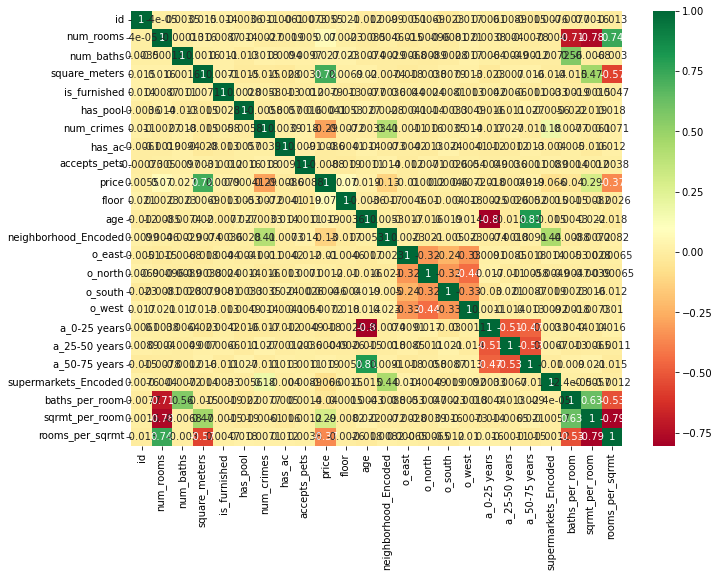

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df[variables].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()

In [69]:
#Measuring Multicolinearity

#find design matrix for regression model using 'rating' as response variable 
y, X = dmatrices('price ~ num_rooms+num_baths+square_meters+num_crimes+floor+neighborhood_Encoded+supermarkets_Encoded+has_ac+has_pool+is_furnished+accepts_pets', data=df, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 

#calculate VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#view VIF for each predictor variable 
print(vif_df)

                variable          VIF
0              Intercept  1483.601308
1              num_rooms     1.000675
2              num_baths     1.001498
3          square_meters     1.001787
4             num_crimes     1.197728
5                  floor     1.001515
6   neighborhood_Encoded     1.439291
7   supermarkets_Encoded     1.242506
8                 has_ac     1.001284
9               has_pool     1.000783
10          is_furnished     1.000690
11          accepts_pets     1.000961


In [64]:
#Change variables again
variables_train = ['id',
 'num_rooms',
 'num_baths',
 'square_meters',
 'num_crimes',
 'price',
 'floor',
 'neighborhood_Encoded',
 'o_east',
 'o_north',
 'o_south',
 'o_west',
 'a_0-25 years',
 'a_25-50 years',
 'a_50-75 years',
 'supermarkets_Encoded','has_ac','has_pool','is_furnished','accepts_pets'
]

In [65]:
#Change variables again
variables_test = ['id',
 'num_rooms',
 'num_baths',
 'square_meters',
 'num_crimes',
 'floor',
 'neighborhood_Encoded',
 'o_east',
 'o_north',
 'o_south',
 'o_west',
 'a_0-25 years',
 'a_25-50 years',
 'a_50-75 years',
 'supermarkets_Encoded',
                  'has_ac','has_pool','is_furnished','accepts_pets'
]

In [66]:
# Final datasets before standarization
data_train = df[variables_train]
data_test = dt[variables_test] 

### Standarization

In [67]:
def standarize_df(df,start_col):
    dz=df.copy()
    for i in df.iloc[:, start_col:].columns:
        if i not in ['price','o_east','o_north','o_south','o_west','a_0-25 years','a_25-50 years','a_50-75 years','has_ac','has_pool','is_furnished','accepts_pets']:
            dz[i] = (df[i] - np.mean(df[i])) / np.std(df[i])
        else:
            dz[i] =  df[i]
    return dz
    

In [68]:
stdz_train = standarize_df(data_train,1)

In [69]:
stdz_test = standarize_df(data_test,1)

In [70]:
#Change variables again
var_train = [
 'num_rooms',
 'num_baths',
 'square_meters',
 'num_crimes',
 'price',
 'floor',
 'neighborhood_Encoded',
 'o_east',
 'o_north',
 'o_south',
 'o_west',
 'a_0-25 years',
 'a_25-50 years',
 'a_50-75 years',
 'supermarkets_Encoded'
    'has_ac','has_pool','is_furnished','accepts_pets'
]

In [71]:
#Change variables again
var_test = [
 'num_rooms',
 'num_baths',
 'square_meters',
 'num_crimes',
 'floor',
 'neighborhood_Encoded',
 'o_east',
 'o_north',
 'o_south',
 'o_west',
 'a_0-25 years',
 'a_25-50 years',
 'a_50-75 years',
 'supermarkets_Encoded'
                  'has_ac','has_pool','is_furnished','accepts_pets'
]

In [72]:
train_df = stdz_train[var_train]

In [73]:
test_df = stdz_test[var_test]

### Cross-validation

In [74]:
stdz_train_1 = train_df.copy()
stdz_test_1 = test_df.copy()

In [79]:
stdz_test_1.head()

,num_rooms,num_baths,square_meters,num_crimes,floor,o_east,o_north,o_south,o_west,a_0-25 years,a_25-50 years,a_50-75 years,supermarkets_Encoded
0,-0.501416,-1.244252,1.213041,-0.787245,0.165116,0,0,0,1,1,0,0,-1.760872
1,0.435226,-0.005368,-0.548098,-0.192761,-1.305305,1,0,0,0,0,0,1,1.101648
2,0.747441,-0.005368,-0.661720,-0.787245,0.165116,0,1,0,0,0,1,0,1.904157
3,0.747441,1.233515,1.553907,1.293447,1.267932,0,0,0,1,1,0,0,-0.628045
4,-0.501416,-1.244252,-0.292449,-0.787245,1.267932,0,1,0,0,0,1,0,-0.567280


In [75]:
# Function to split data
def splitdata(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [76]:
X_train, X_test, y_train, y_test = splitdata(stdz_train_1,'price')

In [78]:
X_train.head()

,num_rooms,num_baths,square_meters,num_crimes,floor,o_east,o_north,o_south,o_west,a_0-25 years,a_25-50 years,a_50-75 years,supermarkets_Encoded
6760,0.458730,1.246714,1.244778,-0.817714,0.491729,1,0,0,0,1,0,0,1.015442
4623,-0.435045,-1.220704,-1.134737,1.517117,-1.356818,0,1,0,0,1,0,0,1.173926
7841,1.352505,-1.220704,1.445460,0.057848,-1.356818,0,0,0,1,0,0,1,1.015442
3704,-1.328820,1.246714,1.588804,-0.525860,-0.617399,0,0,0,1,0,1,0,-0.143029
981,0.458730,-1.220704,-0.790711,-0.817714,1.231148,0,1,0,0,0,0,1,-0.361285


### Model

In [77]:
# Define the features and target
X_train = X_train
X_test = X_test
y_test = y_test
y_train = y_train

# Train the model
# For Logistic Regression:
model = LinearRegression()

model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Compute metrics
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

Train MSE: 28525.52198538634
Test MSE: 29516.537415659073
Train R^2: 0.6139899067904938
Test R^2: 0.5988394254255495


In [ ]:
test_predictions = model.predict(stdz_test_1)

In [ ]:
test_prediction_submit = pd.DataFrame({"id": stdz_test_1["id"],  "price": test_predictions })
test_prediction_submit.to_csv("test_submit.csv", index = False)

## Bivariate Analysis

In [8]:
# Check Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8000 non-null   int64  
 1   num_rooms         8000 non-null   float64
 2   num_baths         7840 non-null   float64
 3   square_meters     7845 non-null   float64
 4   orientation       5659 non-null   object 
 5   year_built        7830 non-null   float64
 6   door              7851 non-null   object 
 7   is_furnished      7835 non-null   object 
 8   has_pool          7844 non-null   object 
 9   neighborhood      7835 non-null   object 
 10  num_crimes        7840 non-null   float64
 11  has_ac            7831 non-null   object 
 12  accepts_pets      7845 non-null   object 
 13  num_supermarkets  1411 non-null   float64
 14  price             8000 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 937.6+ KB


In [9]:
#Calculating the unique values for each column
diction = {}
for i in df.columns:
    unique_vals = np.size(df[i].unique())
    diction[i] = unique_vals
print(pd.DataFrame.from_dict(diction,orient ='index'))

                     0
id                8000
num_rooms           39
num_baths            4
square_meters      179
orientation          6
year_built          73
door                41
is_furnished         3
has_pool             3
neighborhood        11
num_crimes          12
has_ac               3
accepts_pets         3
num_supermarkets     4
price             1279


### Exploring Categorical data

Step 1 - Check all our categorical data

In [10]:
# Creating  a  subset  of  categorical  data
categoricals = ['orientation','is_furnished','has_pool','neighborhood','has_ac','accepts_pets','floor']

In [18]:
for i in df[categoricals].columns:
    a = df[categoricals][i].unique()
    print(i)
    print(a)

orientation
[nan 'west' 'east' 'north' 'south']
is_furnished
[ 0.  1. nan]
has_pool
[ 0.  1. nan]
neighborhood
['Sant Martí' 'Sants' 'Eixample' 'Gràcia' nan 'Les Cors'
 'Sarrià-Sant Gervasi' 'Horta' 'Sant Andreu' 'Ciutat Vella' 'Nou Barris']
has_ac
[ 1.  0. nan]
accepts_pets
[ 1.  0. nan]
floor
[ 3.  7.  1.  6.  5. nan  2.  8.  4.  9.]


In [19]:
# Category proportion %
for i in df[categoricals].columns:
    counts = pd.DataFrame(df[i].value_counts()/df[i].count()).reset_index()
    print(counts)

   index  orientation
0   west     0.258173
1  north     0.250574
2   east     0.247570
3  south     0.243683
   index  is_furnished
0    0.0      0.518315
1    1.0      0.481685
   index  has_pool
0    1.0  0.504207
1    0.0  0.495793
                 index  neighborhood
0                Sants      0.105041
1           Nou Barris      0.104786
2               Gràcia      0.103382
3          Sant Andreu      0.101213
4         Ciutat Vella      0.101213
5           Sant Martí      0.098277
6             Eixample      0.098022
7  Sarrià-Sant Gervasi      0.097128
8                Horta      0.095980
9             Les Cors      0.094959
   index    has_ac
0    1.0  0.504406
1    0.0  0.495594
   index  accepts_pets
0    1.0      0.507967
1    0.0      0.492033
   index     floor
0    1.0  0.195516
1    5.0  0.105210
2    6.0  0.105082
3    9.0  0.104191
4    7.0  0.101261
5    3.0  0.100624
6    8.0  0.099223
7    4.0  0.098714
8    2.0  0.090180


- Orientation: Sample of apartments is well balanced in terms of orientation (~25% each category)
- is_furnished: Half apartments are  furnished
- has_pool: Half apartments have pool
- neighborhood: Sample of apartments is well balanced in terms of neighborhood (~10% each category)
- has_ac: Half apartments have ac
- accepts_pets: half apartments accept pets

### Studying the neighborhoods

In [85]:
df.columns

Index(['id', 'num_rooms', 'num_baths', 'square_meters', 'orientation',
       'year_built', 'door', 'is_furnished', 'has_pool', 'neighborhood',
       'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'price',
       'floor', 'today', 'age', 'neighborhood_Encoded', 'supermarkets_Encoded',
       'age_range', 'o_east', 'o_north', 'o_south', 'o_west', 'a_0-25 years',
       'a_25-50 years', 'a_50-75 years', 'baths_per_room', 'sqrmt_per_room',
       'rooms_per_sqrmt'],
      dtype='object')

In [94]:
variables = ['price', 'num_crimes','floor','num_rooms','num_baths','age']

In [95]:
ng_price_vs_crime = df.groupby(['neighborhood'])[variables].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [96]:
ng_price_vs_crime

,neighborhood,price,num_crimes,floor,num_rooms,num_baths,age
0,Sarrià-Sant Gervasi,1151.980,0.671,4.857,2.484,1.997,37.911
1,Eixample,1143.737,0.957,4.698,2.492,2.030,36.737
2,Les Cors,1127.503,1.434,4.772,2.472,1.969,37.417
3,Gràcia,1117.152,2.204,4.700,2.491,1.988,38.361
4,Horta,1108.239,2.563,4.533,2.513,1.957,38.485
5,Ciutat Vella,1096.231,3.066,4.598,2.429,1.985,37.355
6,Sants,1088.028,3.654,4.672,2.505,1.990,37.481
7,Sant Martí,1067.832,3.479,4.771,2.484,1.972,37.597
8,Sant Andreu,1067.313,4.472,4.600,2.515,2.026,38.352
9,Nou Barris,1038.453,5.084,4.658,2.486,1.976,37.545


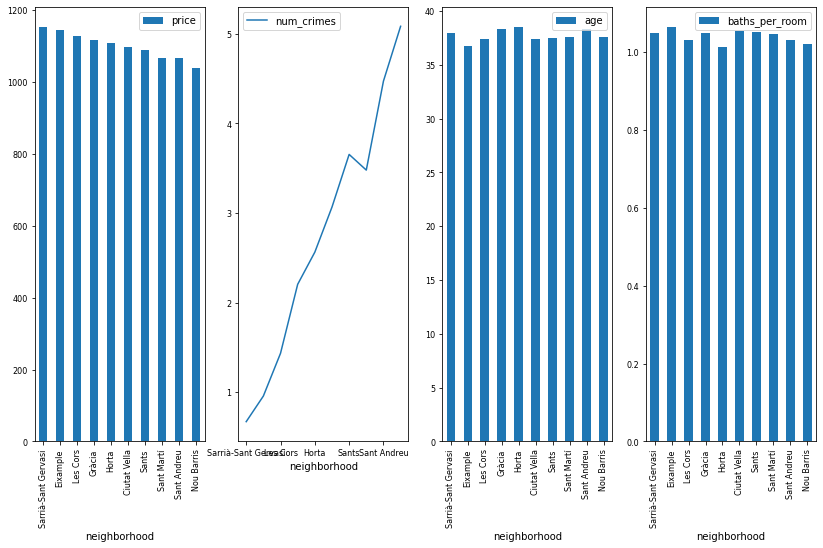

In [74]:
#Plotting both perc and accum
#Plot both mean  and median as lines
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(14,8))
ng_price_vs_crime.plot(x='neighborhood', y='price' , kind= 'bar', ax=ax1,fontsize=8)
ng_price_vs_crime.plot(x='neighborhood', y='num_crimes', kind = 'line',ax = ax2,fontsize=8)
ng_price_vs_crime.plot(x='neighborhood', y='age' , kind= 'bar', ax=ax3,fontsize=8)
ng_price_vs_crime.plot(x='neighborhood', y='baths_per_room' , kind= 'bar', ax=ax4,fontsize=8)

plt.xticks(rotation=90)
plt.show()

Price is influenced by the neighborhood. Most importantly by the crime_rate. The lower the crime rate, the larger the prices 

In [75]:
#  Calculating Frequency tables
frq_table_1 = pd.crosstab(index=df['neighborhood'].astype(str), columns= df['is_furnished'].astype(str),
                        normalize ='index', margins=False).round(2)

### Studying the Apartment Floor

In [77]:
df.columns

Index(['id', 'num_rooms', 'num_baths', 'square_meters', 'orientation',
       'year_built', 'door', 'is_furnished', 'has_pool', 'neighborhood',
       'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'price',
       'floor', 'today', 'age', 'neighborhood_Encoded', 'supermarkets_Encoded',
       'age_range', 'o_east', 'o_north', 'o_south', 'o_west', 'a_0-25 years',
       'a_25-50 years', 'a_50-75 years', 'baths_per_room', 'sqrmt_per_room',
       'rooms_per_sqrmt'],
      dtype='object')

In [79]:
f_price_v = df.groupby('floor')[variables].mean().sort_values(by='price',ascending = False).round(3).reset_index()

ValueError: cannot insert floor, already exists

In [88]:
f_price_v

NameError: name 'f_price_v' is not defined

NameError: name 'f_price_v' is not defined

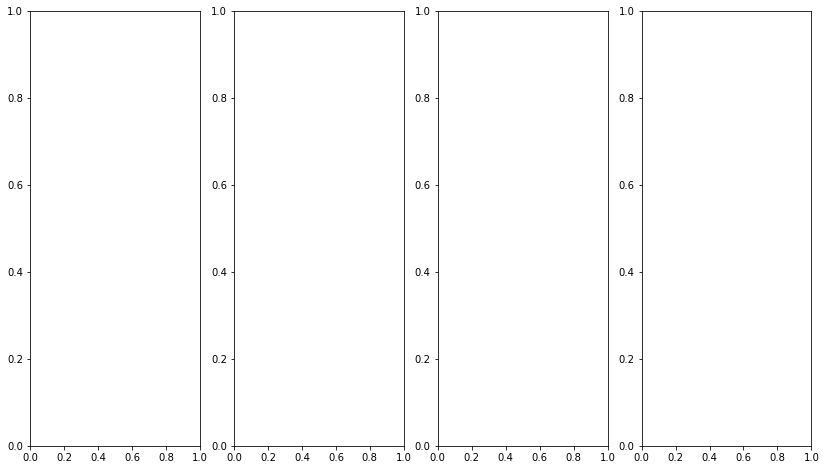

In [90]:
#Plot both mean  and median as lines
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(14,8))
f_price_v.plot(x='floor', y='price' , kind= 'bar', ax=ax1,fontsize=8)
f_price_v.plot(x='floor', y='num_crimes', kind = 'bar',ax = ax2,fontsize=8)
f_price_v.plot(x='floor', y='age' , kind= 'bar', ax=ax3,fontsize=8)
#f_price_v.plot(x='floor', y='rooms_per_sqrtmt' , kind= 'bar', ax=ax4,fontsize=8)
f_price_v.plot(x='floor', y='baths_per_room' , kind= 'bar', ax=ax4,fontsize=8)

plt.xticks(rotation=90)
plt.show()

Clear pattern shows that higher floors have more weight on the apartment price

In [ ]:
#  Calculating Frequency tables
frq_table_1 = pd.crosstab(index=df['floor'].astype(str), columns= df['age_range'].astype(str),
                        normalize ='index', margins=False).round(2)

### Studying Age

In [ ]:
df.columns

In [ ]:
A_price_v = df.groupby(['age_range'])[variables].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [ ]:
A_price_v

In [ ]:
#Plot both mean  and median as lines
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14,8))
A_price_v.plot(x='age_range', y='price' , kind= 'bar', ax=ax1,fontsize=8)
A_price_v.plot(x='age_range', y='num_crimes', kind = 'bar',ax = ax2,fontsize=8)
A_price_v.plot(x='age_range', y='square_meters' , kind= 'bar', ax=ax3,fontsize=8)
A_price_v.plot(x='age_range', y='rooms_per_sqrtmt' , kind= 'bar', ax=ax4,fontsize=8)
A_price_v.plot(x='age_range', y='baths_per_room' , kind= 'bar', ax=ax5,fontsize=8)

plt.xticks(rotation=90)
plt.show()

### Studying Orientation

In [ ]:
df.columns

In [ ]:
o_price_v = df.groupby(['orientation'])[variables].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [ ]:
o_price_v

In [ ]:
#Plot both mean  and median as lines
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14,8))
o_price_v.plot(x='orientation', y='price' , kind= 'bar', ax=ax1,fontsize=8)
o_price_v.plot(x='orientation', y='num_crimes', kind = 'bar',ax = ax2,fontsize=8)
o_price_v.plot(x='orientation', y='square_meters' , kind= 'bar', ax=ax3,fontsize=8)
o_price_v.plot(x='orientation', y='rooms_per_sqrtmt' , kind= 'bar', ax=ax4,fontsize=8)
o_price_v.plot(x='orientation', y='baths_per_room' , kind= 'bar', ax=ax5,fontsize=8)

plt.xticks(rotation=90)
plt.show()

In [ ]:
df.corr()

In [ ]:
lista = df.describe().columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df[variables].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()
